In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_math.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Suffix, single-output decoding',
    'Avg suffix': 'Suffix, average-output decoding',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(
            SUFFIX_LEGEND_REMAP) + ' (' + suffix_results['n_shots'].astype(str) + '-Ex.)'
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))

# import prefix stuff
prefix_results = pickle.load(open('/home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan_2/math/r.pkl', 'rb'))

def make_legend__prefix(table_row: Dict) -> str:
    single_query_str = {
        0: 'average',
        1: 'single'
    }[table_row['single_query']]
    rerank_str = {
        0: '',
        1: ' with reranking'
    }[table_row['do_reranking']]
    
    return 'Prefix, ' + single_query_str + '-output' + rerank_str + f' ({table_row["n_shots"]}-Ex.)'


prefix_results['legend'] = prefix_results.apply(make_legend__prefix, axis=1)
prefix_results = prefix_results.rename(columns={'single_query': 'use_single_query'})

In [32]:
def replace_max_rank(num: int, max_val: int = 10_000) -> int:
    if (num > max_val) or (pd.isna(num)):
        return max_val
    return num
    
prefix_results['final_answer_pos_initial_token'] = prefix_results['final_answer_pos_initial_token'].map(replace_max_rank)
prefix_results = analyze_utils.postprocess_results(prefix_results)
prefix_results['reciprocal_rank'] = prefix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))

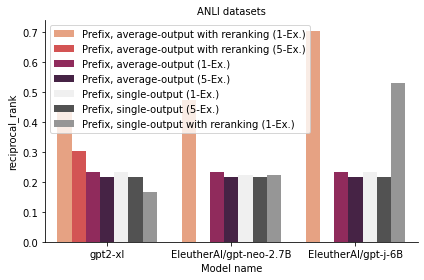

In [33]:
# metric_key = 'final_answer_pos_initial_token'
# metric_key = f'Recall @ {5} suffixes'
metric_key = 'reciprocal_rank'
tab = (
    (prefix_results
        # (mean over templates, task_name)
        .groupby(['checkpoint', 'n_shots', 'do_reranking', 'use_single_query', 'legend'])[[metric_key]]
        .mean()
        .reset_index()
    )
)
analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)

In [34]:
r = pd.concat((prefix_results, suffix_results), axis=0)

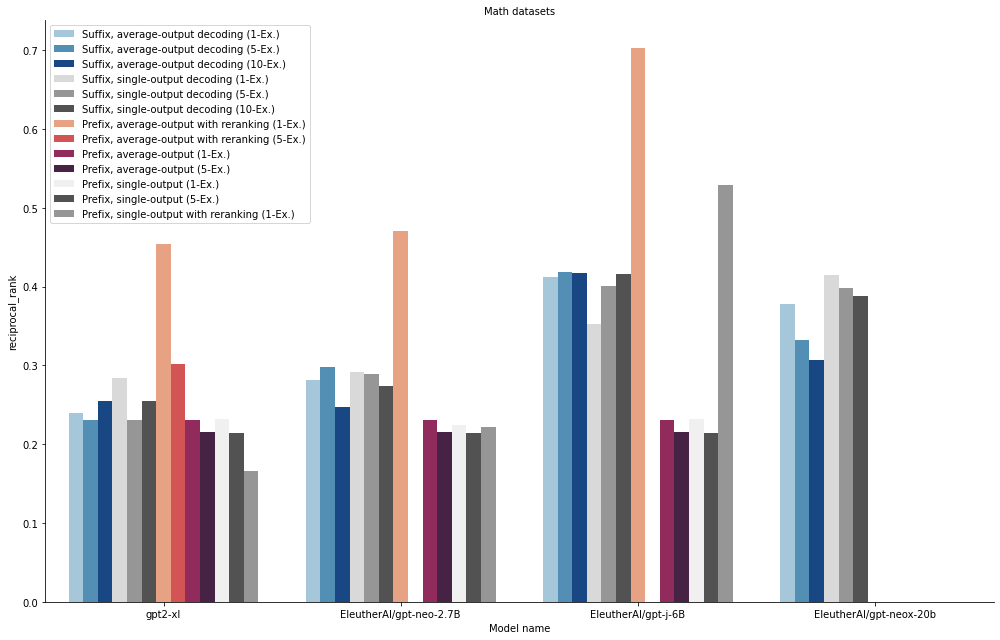

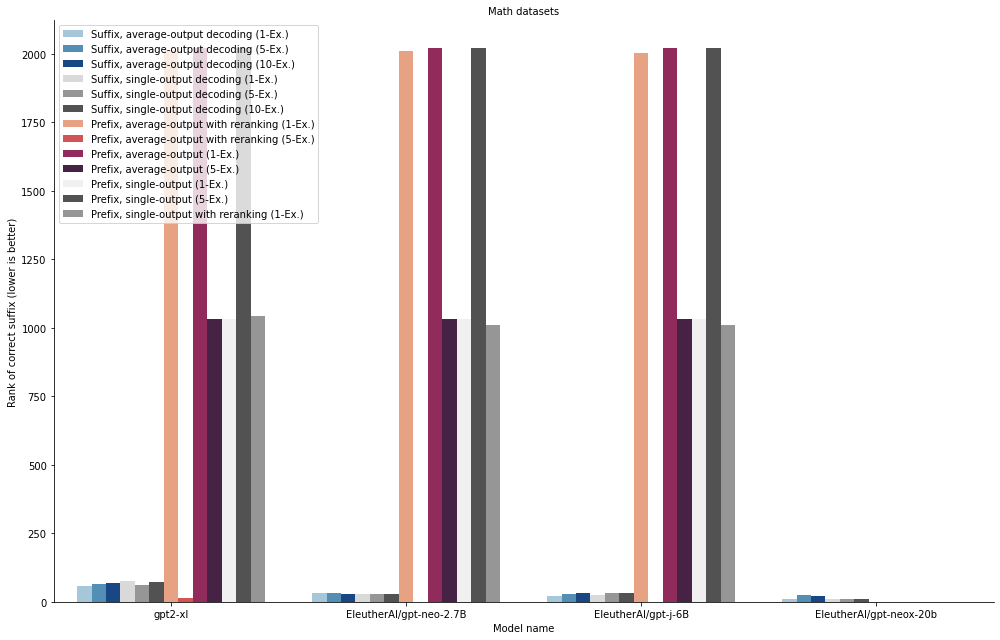

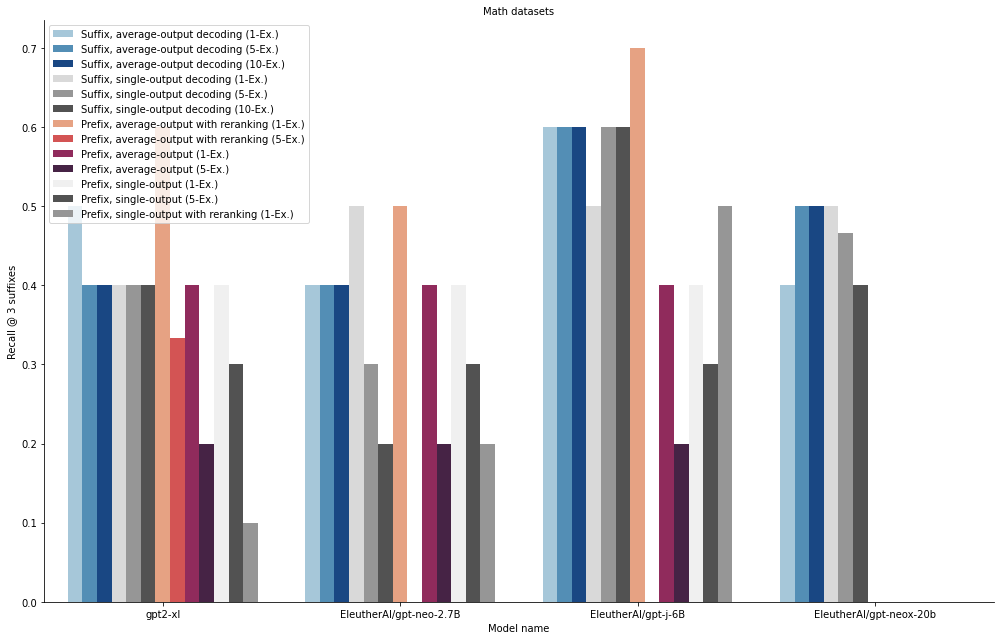

In [35]:
for metric_key in [
                 'reciprocal_rank',
                 'final_answer_pos_initial_token',
                 f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    plt.figure(figsize=(14, 9))
    tab = ((r
            # (mean over templates, task_name)
            .groupby(['checkpoint', 'n_shots', 'do_reranking', 'use_single_query', 'legend'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    analyze_utils.plot_tab(tab, metric_key=metric_key, title='Math datasets', add_legend=False)

    if metric_key == 'final_answer_pos_initial_token':
        plt.savefig('../results/prompt_gen/joint_math_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_math_{metric_key}.pkl')
    # plt.legend('', frameon=False)
    plt.show()

In [27]:
list(sns.color_palette("rocket", n_colors=4).as_hex())

['#4c1d4b', '#a11a5b', '#e83f3f', '#f69c73']

In [26]:
list(sns.color_palette("mako", n_colors=8).as_hex())[4:9]

['#348ba6', '#38aaac', '#55caad', '#a1dfb9']

In [170]:
prefix_results.groupby(['checkpoint', 'n_shots']).count()

index  batch_size  max_dset_size  seed  \
checkpoint              n_shots                                           
EleutherAI/gpt-j-6B     1         2560        5120           5120  5120   
                        5            0        2560           2560  2560   
EleutherAI/gpt-neo-2.7B 1         2560        5120           5120  5120   
                        5            0        2560           2560  2560   
gpt2-xl                 1         2560        5120           5120  5120   
                        5          768        3328           3328  3328   

                                 n_epochs  max_digit  \
checkpoint              n_shots                        
EleutherAI/gpt-j-6B     1            5120       5120   
                        5            2560       2560   
EleutherAI/gpt-neo-2.7B 1            5120       5120   
                        5            2560       2560   
gpt2-xl                 1            5120       5120   
                        5            3328       3328   

                                 template_num_init_string  \
checkpoint              n_shots                             
EleutherAI/gpt-j-6B     1                            5120   
                        5                            2560   
EleutherAI/gpt-neo-2.7B 1                            5120   
                        5                            2560   
gpt2-xl                 1                            5120   
                        5                            3328   

                                 template_num_task_phrasing  save_dir  \
checkpoint              n_shots                                         
EleutherAI/gpt-j-6B     1                              5120      5120   
                        5                              2560      2560   
EleutherAI/gpt-neo-2.7B 1                              5120      5120   
                        5                              2560      2560   
gpt2-xl                 1                              5120      5120   
                        5                              3328      3328   

                                 epoch_save_interval  ...  \
checkpoint              n_shots                       ...   
EleutherAI/gpt-j-6B     1                       5120  ...   
                        5                       2560  ...   
EleutherAI/gpt-neo-2.7B 1                       5120  ...   
                        5                       2560  ...   
gpt2-xl                 1                       5120  ...   
                        5                       3328  ...   

                                 Recall @ 15 suffixes  Recall @ 20 suffixes  \
checkpoint              n_shots                                               
EleutherAI/gpt-j-6B     1                        5120                  5120   
                        5                        2560                  2560   
EleutherAI/gpt-neo-2.7B 1                        5120                  5120   
                        5                        2560                  2560   
gpt2-xl                 1                        5120                  5120   
                        5                        3328                  3328   

                                 Recall @ 25 suffixes  Recall @ 30 suffixes  \
checkpoint              n_shots                                               
EleutherAI/gpt-j-6B     1                        5120                  5120   
                        5                        2560                  2560   
EleutherAI/gpt-neo-2.7B 1                        5120                  5120   
                        5                        2560                  2560   
gpt2-xl                 1                        5120                  5120   
                        5                        3328                  3328   

                                 Recall @ 40 suffixes  Recall @ 50 suffixes  \
checkpoint              n_shots                                            